In [177]:
import pandas as pd
import random
import numpy as np
import copy
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import collections
from collections import deque, defaultdict

In [178]:
class QuantumNetwork:
    def __init__(self, initialEdges, pGen, pSwap, cutOffAge, nodeCapacity):
        self.initialEdges = initialEdges
        self.pGen = pGen
        self.pSwap = pSwap
        self.cutOffAge = cutOffAge
        self.nodeCapacity = nodeCapacity  # Dictionary mapping node -> max entanglements
        
        self.G = nx.Graph()
        nodes = set()
        for edge in self.initialEdges:
            nodes.add(edge[0])
            nodes.add(edge[1])
        self.G.add_nodes_from(sorted(nodes))
    
    def reset(self):
        self.G = nx.Graph()
        nodes = set()
        for edge in self.initialEdges:
            nodes.add(edge[0])
            nodes.add(edge[1])
        self.G.add_nodes_from(nodes)
    
    def setState(self, state):
        self.G = nx.Graph()
        for edge, entanglements in state.items():
            self.G.add_edge(*edge, entanglements=deque(entanglements))
    
    def getNodeEntanglementCount(self, node):
        return sum(len(self.G.edges[e]['entanglements']) 
                  for e in self.G.edges(node)) if self.G.degree(node) > 0 else 0
        
    def generateLocalEntanglement(self, node1, node2):
        edge = tuple(sorted([node1, node2]))
        
        # Check if either node has reached its capacity
        node1_count = self.getNodeEntanglementCount(node1)
        node2_count = self.getNodeEntanglementCount(node2)
        
        if (node1_count >= self.nodeCapacity[node1] or 
            node2_count >= self.nodeCapacity[node2]):
            return 
        
        if not self.G.has_edge(*edge):
            self.G.add_edge(*edge, entanglements=deque([0]))
        else:
            self.G.edges[edge]['entanglements'].appendleft(0)
            
    def getState(self):
        edge_info = {}
        for edge in self.G.edges():
            edge_info[edge] = list(self.G.edges[edge]['entanglements']) 
        return edge_info
        
    def ageEntanglements(self):
        edges_to_check = list(self.G.edges())  # Create a copy of edges to iterate over
        for edge in edges_to_check:
            entanglements = self.G.edges[edge]['entanglements']
            # Remove entanglements that would exceed cutOffAge
            while entanglements and entanglements[-1] + 1 > self.cutOffAge:
                self.discardEntanglement(edge)
            # Age remaining entanglements
            if self.G.has_edge(*edge):  # Check if edge still exists
                entanglements = self.G.edges[edge]['entanglements']
                self.G.edges[edge]['entanglements'] = deque(age + 1 for age in entanglements)
    
    def generateGlobalEntanglementsProbabalistically(self):
        for edge in self.initialEdges:
            if random.random() < self.pGen:
                self.generateLocalEntanglement(*edge)

    def discardEntanglement(self, edge: tuple):
        if self.G.has_edge(*edge):
            if len(self.G.edges[edge]['entanglements']) > 0:
                self.G.edges[edge]['entanglements'].pop()
            if len(self.G.edges[edge]['entanglements']) == 0:
                self.G.remove_edge(*edge)
                
         
    def drawNetwork(self):
        plt.figure(figsize=(12, 8))
        plt.clf()
        
        G_viz = self.G.copy()
        G_viz.add_edges_from(self.initialEdges)
        
        # FIXED POSITION FOR DUMBELL NETWORK
        pos = {
            0: (-1, 0.5),   # Top left
            1: (-1, -0.5),  # Bottom left
            2: (0, 0),      # Center
            3: (1, 0),      # Center right
            4: (2, 0.5),    # Top right
            5: (2, -0.5)    # Bottom right
        }
        # pos = nx.spring_layout(G_viz, seed=27)

        nx.draw_networkx_edges(G_viz, pos=pos, 
                            edgelist=self.initialEdges,
                            edge_color='grey',
                            style='dashed',
                            alpha=0.5)
        
        for edge in self.G.edges():
            entanglements = self.G.edges[edge]['entanglements']
            for i, age in enumerate(entanglements):
                nx.draw_networkx_edges(G_viz, pos=pos,
                                    edgelist=[edge],
                                    edge_color='blue',
                                    width=2,
                                    arrows=True,
                                    connectionstyle=f'arc3, rad={-0.1 + i*0.2}')
                
                edge_x = (pos[edge[0]][0] + pos[edge[1]][0]) / 2
                edge_y = (pos[edge[0]][1] + pos[edge[1]][1]) / 2
                offset = -0.1 + i*0.2
                label_x = edge_x + offset * (pos[edge[1]][1] - pos[edge[0]][1]) / 2
                label_y = edge_y - offset * (pos[edge[1]][0] - pos[edge[0]][0]) / 2
                plt.text(label_x, label_y, str(age), 
                        bbox=dict(facecolor='white', edgecolor='lightgray', alpha=0.7))
        
        nx.draw_networkx_nodes(G_viz, pos=pos, node_color='lightblue')
        nx.draw_networkx_labels(G_viz, pos=pos)
        
        plt.show()

###############################
###############################
###############################

class WaitSwapEnvironment(QuantumNetwork):
    def __init__(self, initialEdges, pGen, pSwap, cutOffAge, nodeCapacity, goalEdgesAndWeights, n):
        super().__init__(initialEdges, pGen, pSwap, cutOffAge, nodeCapacity)
        self.goalEdgesAndWeights = goalEdgesAndWeights
        self.timestep = 0  # Track total timesteps
        self.sumExists = defaultdict(lambda: 1)  # Track sum of times each goal edge exists
        self.n = n 
        
    def getReward(self):
        total_reward = 0
        
        for goal_edge, weight in self.goalEdgesAndWeights:
            sorted_goal = tuple(sorted(goal_edge))
            
            if self.G.has_edge(*sorted_goal):
                path = nx.shortest_path(self.G, sorted_goal[0], sorted_goal[1])
                num_elementary_edges = len(path) - 1
                
                instantaneousRate = self.pSwap ** num_elementary_edges
                if self.timestep > 0:
                    if self.sumExists[sorted_goal] > 0:
                        averageRate = self.sumExists[sorted_goal] / self.timestep
                    else:
                        averageRate = 1 
                else:
                    averageRate = 1
                
                edge_reward = (instantaneousRate / averageRate) * weight
                
                total_reward += edge_reward

        return total_reward

    def updateRateParameters(self):
        for goal_edge, _ in self.goalEdgesAndWeights:
            sorted_goal = tuple(sorted(goal_edge))
            self.sumExists[sorted_goal] += int(self.G.has_edge(*sorted_goal))
    
    def copy(self):
        new_env = WaitSwapEnvironment(
            initialEdges=self.initialEdges.copy(),  # Use copy to ensure a new list is created
            pGen=self.pGen,
            pSwap=self.pSwap,
            cutOffAge=self.cutOffAge,
            nodeCapacity=self.nodeCapacity,
            goalEdgesAndWeights=self.goalEdgesAndWeights,
            n=self.n,
        )
        
        new_env.G = self.G.copy()
        
        for edge in new_env.G.edges():
            new_env.G.edges[edge]['entanglements'] = deque(self.G.edges[edge]['entanglements'])
        new_env.timestep = self.timestep
        new_env.sumExists = self.sumExists.copy()
        
        return new_env

    def takeAction(self, action):
        swaps, goal = action  # Unpack the tuple
        if swaps:
            max_age = 0
            for edge1, edge2 in swaps:
                if self.G.has_edge(*edge1):
                    max_age = max(max_age, max(self.G.edges[edge1]['entanglements']))
                if self.G.has_edge(*edge2):
                    max_age = max(max_age, max(self.G.edges[edge2]['entanglements']))
                
                self.discardEntanglement(edge1)
                self.discardEntanglement(edge2)

            if goal:
                edge = tuple(sorted(goal))
                if not self.G.has_edge(*edge):
                    self.G.add_edge(*edge, entanglements=deque([max_age]))
                else:
                    self.G.edges[edge]['entanglements'].appendleft(max_age)


    
    def getPossibleActions(self):
        possible_actions = []
        
        for goal_edge, _ in self.goalEdgesAndWeights:
            start_node, end_node = goal_edge
            
            if nx.has_path(self.G, start_node, end_node):
                paths = list(nx.all_simple_paths(self.G, start_node, end_node))
                for path in paths:
                    path_edges = []
                    for i in range(len(path)-1):
                        edge = tuple(sorted([path[i], path[i+1]]))
                        path_edges.append(edge)
                    
                    has_entanglements = all(
                        self.G.has_edge(*edge) or self.G.has_edge(*tuple(reversed(edge)))
                        for edge in path_edges
                    )
                    
                    if has_entanglements:
                        possible_actions.append((
                            [(edge1, edge2) for edge1, edge2 in zip(path_edges[:-1], path_edges[1:])],
                            goal_edge
                        ))
        
        possible_actions.append(([], None))
        return possible_actions
    
    def getActionEpsilonGreedyPolicy(self,Q, state, epsilon):
        actions_and_values = Q.getActionAndValues(state)
        if not actions_and_values:
            possible_actions = self.getPossibleActions()
            return random.choice(possible_actions)
        
        if np.random.rand() < epsilon:
            return random.choice(actions_and_values)[0]
        else:
            return max(actions_and_values, key=lambda x: x[1])[0]

In [179]:
class QTable: 
    def __init__(self):
        self.Q = defaultdict(lambda: defaultdict(lambda: 0.0))
    
    def _state_to_tuple(self, state):
        return tuple(sorted((edge, tuple(sorted(ages))) for edge, ages in state.items()))
    
    def storeStateActionValue(self, state, action, value):
        state_tuple = self._state_to_tuple(state)
        # Convert the second part of the action to a tuple
        action_tuple = (tuple(action[0]), tuple(action[1]) if action[1] is not None else ())
        self.Q[state_tuple][action_tuple] = value

    def getValue(self, state, action):
        # Convert the second part of the action to a tuple
        action_tuple = (tuple(action[0]), tuple(action[1]) if action[1] is not None else ())
        state_tuple = self._state_to_tuple(state)
        return self.Q[state_tuple][action_tuple]

    def getActionAndValues(self, state):
        state_tuple = self._state_to_tuple(state)
        return [(action, value) for action, value in self.Q[state_tuple].items()]


In [180]:
# For some reason, the seed needs to be set here, otherwise the results are different every time
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
# Initalise Network
nodeCapacity = {
    0: 1,  
    1: 1,  
    2: 3,  
    3: 3, 
    4: 1,  
    5: 1
}
initialEdges = [
    (0, 2),
    (1, 2),
    (2, 3),
    (3, 4),
    (3, 5)]
goalEdgesAndWeights = [((0,5), 0.7), ((1,4), 0.3)]
pGen = 0.8
pSwap = 1
cutOffAge = 1   
n = 3

network = WaitSwapEnvironment(initialEdges=initialEdges,pGen=pGen,pSwap=pSwap, cutOffAge=cutOffAge, nodeCapacity=nodeCapacity, goalEdgesAndWeights=goalEdgesAndWeights, n=n) 
Q= QTable()


network.generateGlobalEntanglementsProbabalistically()
network.generateGlobalEntanglementsProbabalistically()

network.getPossibleActions()
Q.storeStateActionValue(network.getState(), network.getPossibleActions()[0], 1234)
print(Q.getValue(network.getState(), network.getPossibleActions()[0]))


1234


In [202]:
nodeCapacity = {
    0: 1,  
    1: 1,  
    2: 3,  
    3: 3, 
    4: 1,  
    5: 1
}
initialEdges = [
    (0, 2),
    (1, 2),
    (2, 3),
    (3, 4),
    (3, 5)]
goalEdgesAndWeights = [((0,5), 0.7), ((1,4), 0.3)]
gamma = 0.1
pGen = 0.8
pSwap = 1
cutOffAge = 2
episodes = 100
alpha = 0.1
n = 3
steps = 100
epsilon = 0.1
network = WaitSwapEnvironment(initialEdges=initialEdges,pGen=pGen,pSwap=pSwap, cutOffAge=cutOffAge, nodeCapacity=nodeCapacity, goalEdgesAndWeights=goalEdgesAndWeights, n=n) 


In [203]:
Q = QTable()
# Function to get the greedy action based on Q-values
def getGreedyAction(Q, state, possible_actions):
    return max(possible_actions, key=lambda x: Q.getValue(state, x))

# Logging for the edr
goal_1 = (0, 5) # Done manually for now
goal_2 = (1, 4)
edr_goal_1 = []
edr_goal_2 = []
timesteps = []



# We don't have terminal states, just continuous, so we remove T and terminal checks
for episode in range(episodes):
    # Reset and prepare the network for a new episode
    network.reset()
    network.generateGlobalEntanglementsProbabalistically()
    
    # Inital states and actions
    states = [network.getState()]
    chosenAction = network.getActionEpsilonGreedyPolicy(Q, states[-1], epsilon)
    actions = [chosenAction]
    rewards = []  # Is this correct?
    # [A_t, S_t, R_t+1] [A_t+1, S_t+1, R_t+2] [A_t+2, S_t+2, R_t+3]
    
    for t in range(steps): 

        #Take action A_{t}, and store next reward and state as R_{t+1}, S_{t+1}
        network.takeAction(actions[-1])
        states.append(network.getState())
        reward = network.getReward()
        rewards.append(reward)
        
        # Choose an action A_{t+1} artibrarily as a function of S_{t+1}; Store as A_{t+1}
        possibleActions = network.getPossibleActions()
        action = random.choice(possibleActions) # why is this random?
        actions.append(action)
        
         # Take a step
        network.timestep += 1
        network.ageEntanglements()
        network.updateRateParameters()
        
        tau = t - n + 1 # 't' is the time when we start upating tau w.r.t to n lag 
        if tau >= 0:
            G_1 = rewards[tau] # Initalise with the reward received at time tau + 1
            if tau + 1 < steps: # Check if there is a next state to consider for future rewards
                next_state = states[tau + 1] # the next state that was taken S_{t+1}
                next_possible_actions = network.getPossibleActions() # To be used in the expected value
                expected_value = 0
                for a in next_possible_actions:
                    action_prob = epsilon / len(next_possible_actions)
                    # For epsilon-greedy, non-optimal actions share epsilon probability equally
                    # If 'a' is the best action, adjust the probability for exploitation
                    if a == max(next_possible_actions, key=lambda x: Q.getValue(next_state, x)):
                        action_prob += (1 - epsilon)
                    # Add the weighted Q-value of the action to the expected value
                    expected_value += action_prob * Q.getValue(next_state, a)
                G_1 += gamma * expected_value

            # Initialize G_2 with G_1
            G_2 = G_1
            
            # Loop from t down to tau + 1
            for k in range(t, tau, -1):
                state_k = states[k]
                action_k = actions[k]
                
                # Calculate the expected value for actions other than A_k
                expected_value = 0
                for a in next_possible_actions:
                    if a != action_k:#. if_not_the_action_taken
                        action_prob = epsilon / len(next_possible_actions)
                        if a == max(next_possible_actions, key=lambda x: Q.getValue(state_k, x)):
                            action_prob += (1 - epsilon)
                        expected_value += action_prob * Q.getValue(state_k, a)
                                
                # Add the contribution of A_k
                action_prob = epsilon / len(next_possible_actions)
                if action_k == max(next_possible_actions, key=lambda x: Q.getValue(state_k, x)):
                    action_prob += (1 - epsilon)
                
                # Update G_2 with the reward and expected values
                G_2 = rewards[k] + gamma * (expected_value + action_prob * G_2)
                # Get the state and action at time tau
            state_tau = states[tau]
            action_tau = actions[tau]
            # Retrieve the current Q-value for the state-action pair
            Q_value = Q.getValue(state_tau, action_tau)
            # Update the Q-value using the calculated G_2 and learning rate alpha
            Q.storeStateActionValue(state_tau, action_tau, Q_value + alpha * (G_2 - Q_value))
     
    
    edr_1 = network.sumExists[goal_1] / network.timestep
    edr_2 = network.sumExists[goal_2] / network.timestep
    edr_goal_1.append(edr_1)
    edr_goal_2.append(edr_2)
    timesteps.append(episode)
    
        

dict_items([((0, 5), 62), ((1, 4), 53)])
10000


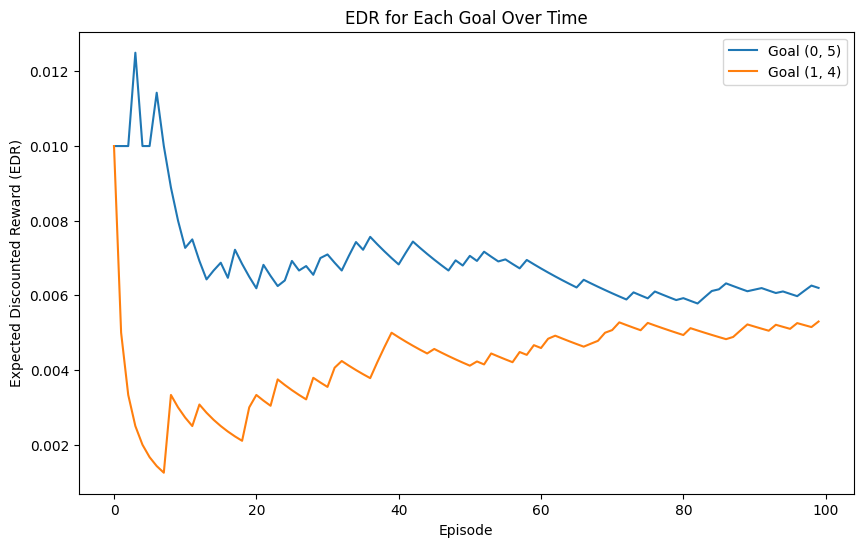

In [204]:
print(network.sumExists.items())
print(network.timestep)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(timesteps, edr_goal_1, label=f'Goal {goal_1}')
plt.plot(timesteps, edr_goal_2, label=f'Goal {goal_2}')
plt.xlabel('Episode')
plt.ylabel('Expected Discounted Reward (EDR)')
plt.title('EDR for Each Goal Over Time')
plt.legend()
plt.show()

In [184]:
# Get the top 10 actions, states with the highest Q-values in the Q-table
top_actions = sorted(Q.getActionAndValues(network.getState()), key=lambda x: x[1], reverse=True)[:10]
top_states = sorted(Q.getActionAndValues(network.getState()), key=lambda x: x[1], reverse=True)[:10]
print(top_actions)
print(top_states)

[(((), ()), 0.0)]
[(((), ()), 0.0)]
